Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [33]:
# Need external libries
!pip install pdpbox
!pip install yfinance
!pip install python-edgar

In [34]:
# import the libraries
import yfinance as yf
import numpy as np
import pandas as pd
import edgar

In [35]:
# Load the stock
stock = yf.Ticker('AAPL')

# Get the historical data
df = stock.history(period='max')

In [36]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.101087,0.101526,0.101087,0.101087,469033600,0.0,0.0
1980-12-15,0.096252,0.096252,0.095813,0.095813,175884800,0.0,0.0
1980-12-16,0.089220,0.089220,0.088780,0.088780,105728000,0.0,0.0
1980-12-17,0.090978,0.091418,0.090978,0.090978,86441600,0.0,0.0
1980-12-18,0.093615,0.094055,0.093615,0.093615,73449600,0.0,0.0


In [37]:
# Take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10091 entries, 1980-12-12 to 2020-12-18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10091 non-null  float64
 1   High          10091 non-null  float64
 2   Low           10091 non-null  float64
 3   Close         10091 non-null  float64
 4   Volume        10091 non-null  int64  
 5   Dividends     10091 non-null  float64
 6   Stock Splits  10091 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 630.7 KB


In [38]:
# Add the price change feature
df['DailyChange'] = df['Close'] - df['Open']

In [39]:
# Add the price change feature
df['VolumeChange'] = df['Volume'].shift(-1) - df['Volume']

In [40]:
# Add the price change feature
df['PriceDiff'] = df['Close'].shift(-1) - df['Close']

In [41]:
# Return for the day
df['Return'] = df['PriceDiff'] / df['Close']

In [42]:
# Daily difference in price
df['OpenChange'] = df['High'] - df['Low']

In [43]:
# Moving Average 50 and 250 days to get signal
df['MA50'] = df['Close'].rolling(100).mean()
df['MA250'] = df['Close'].rolling(200).mean()
df['Signal'] = df['MA50'] - df['MA250']

# Signal direction.
df['SignalD'] = [1 if df.loc[signal, 'Signal'] > 0 else 0 for signal in df.index]
df['SignalD'] = df['SignalD'].astype('int')

In [44]:
# Drop the any create from the three features from above
df.fillna(df.mean(), inplace=True)

In [45]:
# Create the target feature to predict.
# I want to know if the market up or down.
df['Direction'] = [1 if df.loc[direction, 'Return'] > 0 else 0 for direction in df.index]
df['Direction'] = df['Direction'].astype('int')
df['Direction'].value_counts(normalize=True)

0    0.503914
1    0.496086
Name: Direction, dtype: float64

In [46]:
# Drop the leakage columns
df = df.drop(['Return','PriceDiff'], axis=1)

In [47]:
# Choose your target. Which column in your tabular dataset will you predict?
# I will predict Price

In [48]:
# Is your problem regression or classification?
# It will be a regression

In [49]:
# How is your target distributed?
# This is a continus problem because it is a price of a stock

In [50]:
# My evaluation metrics.
# Accuracy Score

In [51]:
# I will train from 1980 to 2004, validate from 2005 to 2014, and test from 2015 to 2019
# I will do time base split.

# get the date column from the index
df['Date'] = df.index

# Split the data
train = df[(df['Date'].dt.year <= 2004)]
val = df[(df['Date'].dt.year >= 2005) & (df['Date'].dt.year <= 2014)]
test = df[(df['Date'].dt.year >= 2015)]

In [52]:
####################### Fisnish retro 1 ####################

In [53]:
####################### Start retro 2 ####################

In [54]:
# Take a look at the data
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6071 entries, 1980-12-12 to 2004-12-31
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          6071 non-null   float64       
 1   High          6071 non-null   float64       
 2   Low           6071 non-null   float64       
 3   Close         6071 non-null   float64       
 4   Volume        6071 non-null   int64         
 5   Dividends     6071 non-null   float64       
 6   Stock Splits  6071 non-null   float64       
 7   DailyChange   6071 non-null   float64       
 8   VolumeChange  6071 non-null   float64       
 9   OpenChange    6071 non-null   float64       
 10  MA50          6071 non-null   float64       
 11  MA250         6071 non-null   float64       
 12  Signal        6071 non-null   float64       
 13  SignalD       6071 non-null   int64         
 14  Direction     6071 non-null   int64         
 15  Date          6071 n

In [55]:
####################### Fisnish retro 2 ####################

In [56]:
####################### Start retro 3 ####################

In [57]:
# Baseline
baseline = train['Direction'].value_counts(normalize=True)
print('Majority Baseline:', baseline[0])

Majority Baseline: 0.527260747817493


In [58]:
# Create the new DataFrame to get the feature list
target = 'Direction'
df_drop = train.copy()

# Features DataFrame 
df_drop = df_drop.drop(target,axis=1)

# get the feature columns list
numeric = df_drop.describe().columns.values.tolist()

# Processor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


numeric_features = numeric

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', DecisionTreeClassifier())])

In [59]:
# Create the training and test sets
X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

# Fit the model
clf.fit(X_train,y_train)
print('Validation Accuracy', clf.score(X_val, y_val))

Validation Accuracy 0.4958283671036949


In [60]:
# Import the Accuracy Score test
from sklearn.metrics import accuracy_score

# Do the predict on the test set
y_pred = clf.predict(X_test)

# Get the Accuracy Score score
print('The Accuracy Score:',accuracy_score(y_test,y_pred))

The Accuracy Score: 0.5216234198270127


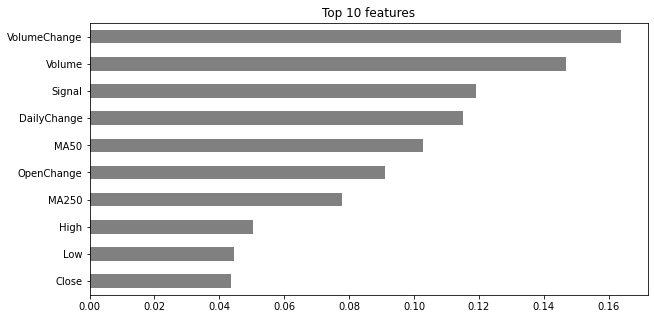

In [61]:
# Features (order in which they were preprocessed)
features_order = numeric_features

importances = pd.Series(clf.steps[1][1].feature_importances_, features_order)

# Plot feature importances
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

plt.show()

In [62]:
# Permute the values in the more important column
feature = 'VolumeChange'

X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  VolumeChange
Validation Accuracy 0.5216234198270127
Validation Accuracy (permuted) 0.499001996007984


In [63]:
# Permute the values in the more important column
feature = 'Dividends'

X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  Dividends
Validation Accuracy 0.5216234198270127
Validation Accuracy (permuted) 0.5216234198270127


In [64]:
# Remove the date from the data for using XGBoost
X_test = X_test.drop('Date', axis=1)

# Load xgboost and fit the model
from xgboost import XGBClassifier

xg_classifier = XGBClassifier(n_estimators=250, random_state=42)

xg_classifier.fit(X_test,y_test)

print('Validation Accuracy: XGBoost', xg_classifier.score(X_test, y_test))

Validation Accuracy: XGBoost 0.8616101131071191


In [65]:
####################### Fisnish retro 3 ####################

In [66]:
####################### Start retro 4 ####################

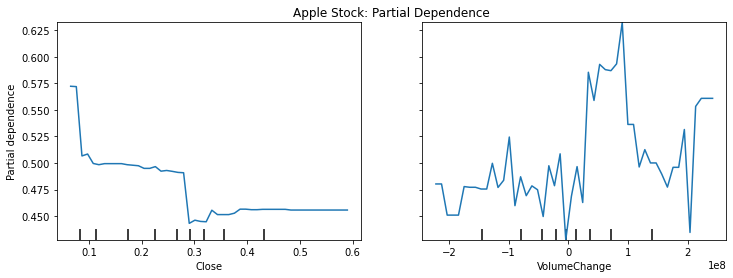

In [67]:
# Partial dependence
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

model = clf.fit(X_train,y_train)

fig, ax = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(model, feature_names=X_train.columns, 
                        features=['Close', 'VolumeChange'], 
                        X=X_train, grid_resolution=50, ax=ax);

ax.set_title('Apple Stock: Partial Dependence');

plt.show();

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


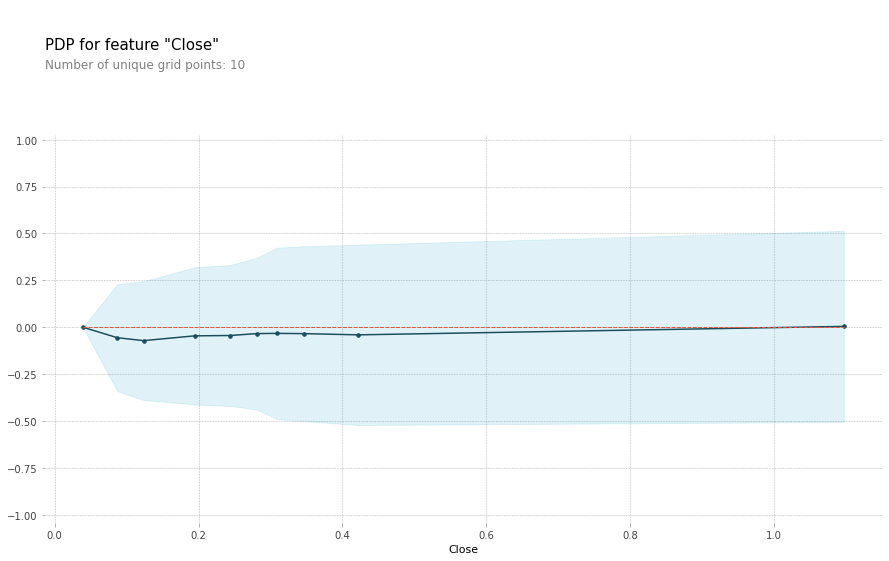

In [68]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Create the plot for a single feature isolated

isolated = pdp_isolate(
    model= model,
    dataset=X_train,
    model_features=X_train.columns,
    feature='Open'
)

pdp_plot(isolated, feature_name='Close');

plt.show();

In [ ]:
####################### Fisnish retro 4 ####################